In [11]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and drop unneeded columns
df = pd.read_csv("housedata.csv")
df.drop(['SizeRank', 'RegionType', 'RegionName', 'StateName', 'Metro', 'CountyName'], 
        axis=1, inplace=True)


In [12]:
!pip install pmdarima

In [13]:
# Identify columns to skip
skip_cols = ['RegionID', 'State', 'City']
value_cols = [c for c in df.columns if c not in skip_cols]

# Fill missing values row-wise using row-wise min, then row-wise max
df[value_cols] = df[value_cols].apply(lambda row: row.fillna(row.mean()), axis=1)
df[value_cols] = df[value_cols].apply(lambda row: row.fillna(row.max()), axis=1)

# Check if any NaNs remain
print("Remaining NaNs per column:")
print(df.isna().sum())

Remaining NaNs per column:
RegionID         0
State            0
City          1041
2000-01-31       0
2000-02-29       0
2000-03-31       0
2000-04-30       0
2000-05-31       0
2000-06-30       0
2000-07-31       0
2000-08-31       0
2000-09-30       0
2000-10-31       0
2000-11-30       0
2000-12-31       0
2001-01-31       0
2001-02-28       0
2001-03-31       0
2001-04-30       0
2001-05-31       0
2001-06-30       0
2001-07-31       0
2001-08-31       0
2001-09-30       0
2001-10-31       0
2001-11-30       0
2001-12-31       0
2002-01-31       0
2002-02-28       0
2002-03-31       0
2002-04-30       0
2002-05-31       0
2002-06-30       0
2002-07-31       0
2002-08-31       0
2002-09-30       0
2002-10-31       0
2002-11-30       0
2002-12-31       0
2003-01-31       0
2003-02-28       0
2003-03-31       0
2003-04-30       0
2003-05-31       0
2003-06-30       0
2003-07-31       0
2003-08-31       0
2003-09-30       0
2003-10-31       0
2003-11-30       0
2003-12-31       0
2004

In [14]:
# Unpivot the dataframe

unpivoted_df = df.melt(id_vars=['RegionID', 'State', 'City'], value_vars=[c for c in df.columns if c not in ['RegionID', 'State', 'City']], var_name='Date', value_name='House price')

# Select a specific region

interested_zip_code = 91733

arima_df = unpivoted_df.loc[unpivoted_df['RegionID'] == interested_zip_code].copy()

arima_df['Date'] = pd.to_datetime(arima_df['Date'])

arima_df.set_index('Date', inplace=True)

arima_df = arima_df.sort_index()

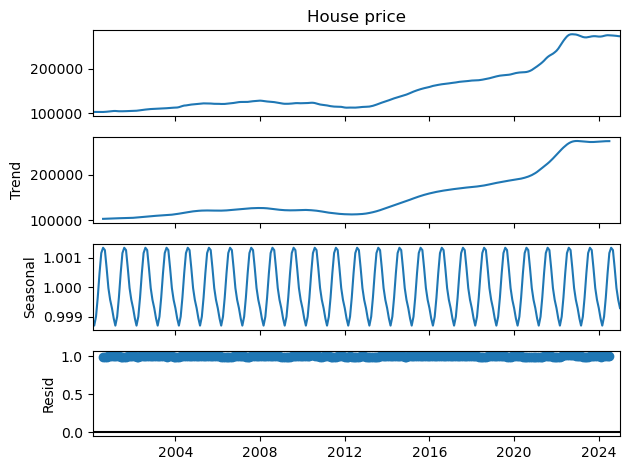

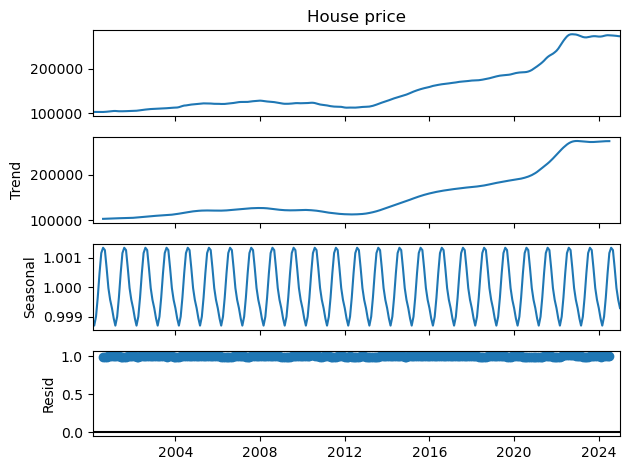

In [15]:
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(arima_df['House price'],  
                            model ='multiplicative') 
result.plot()

In [ ]:
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(arima_df['House price'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 36, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[36]             : AIC=4464.498, Time=15.47 sec
 ARIMA(0,1,0)(0,1,0)[36]             : AIC=4585.444, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[36]             : AIC=4542.657, Time=8.85 sec
 ARIMA(0,1,1)(0,1,1)[36]             : AIC=4553.330, Time=2.80 sec
 ARIMA(1,1,1)(0,1,0)[36]             : AIC=4466.314, Time=0.71 sec


In [ ]:
train = arima_df.iloc[:len(arima_df)-12] 
test = arima_df.iloc[len(arima_df)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train['House price'],  
                order = (1, 0, 1),  
                seasonal_order =(1, 1, 1, 12)) 

result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        House price   No. Observations:                  288
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -2811.259
Date:                            Sun, 04 Jan 2026   AIC                           5632.518
Time:                                    16:30:52   BIC                           5650.620
Sample:                                01-31-2000   HQIC                          5639.782
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.037     26.871      0.000       0.926       1.071
ma.L1          0.0891      0.094      0.949      0.343      -0.095       0.273
ar.S.L12      -0.9998      0.002   -529.202      0.000      -1.003      -0.996
ma.S.L12       0.9803      0.090     10.923      0.000       0.804       1.156
sigma2      3.797e+07   1.76e-09   2.16e+16      0.000     3.8e+07     3.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             74956.43
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -6.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        82.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+31. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

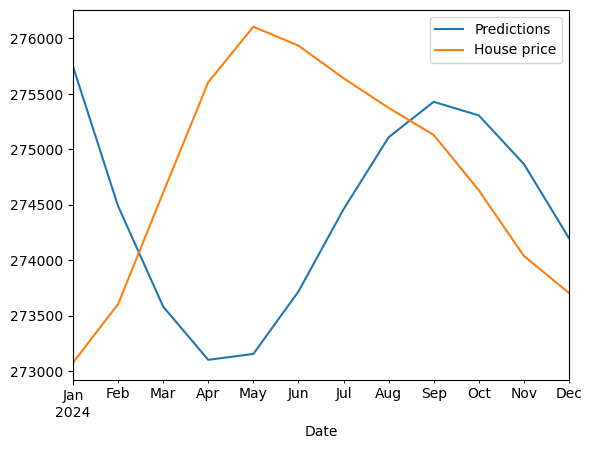

In [ ]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['House price'].plot(legend = True)

In [ ]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print(rmse(test["House price"], predictions)) 
  
# Calculate mean squared error 
print(mean_squared_error(test["House price"], predictions))

1627.6258268662793
2649165.8322821395


<Axes: xlabel='Date'>

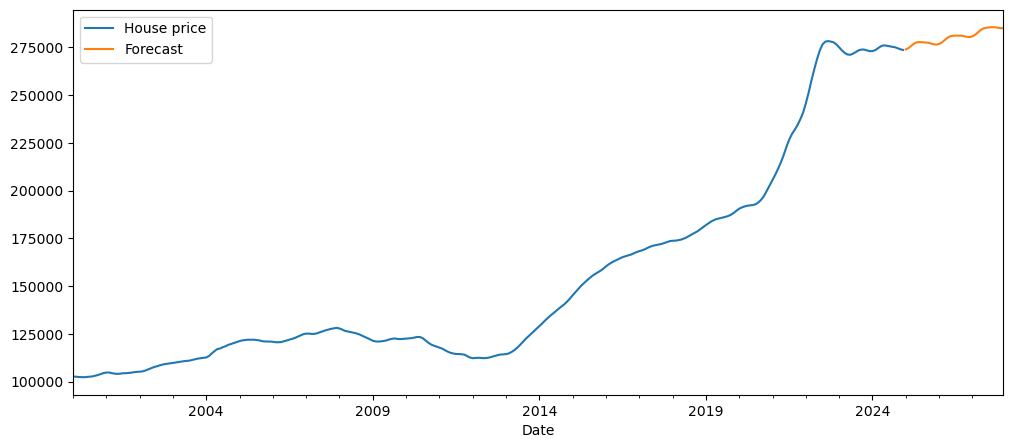

In [ ]:
# Train the model on the full dataset 
model = model = SARIMAX(arima_df['House price'],  
                        order = (0, 1, 1),  
                        seasonal_order =(2, 1, 1, 12)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(arima_df),  
                          end = (len(arima_df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
arima_df['House price'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True)